In [2]:
import torch
import numpy as np
from paper_figure_scripts.load_data2 import load_data
import matplotlib.pyplot as plt
import mne

import json

def load_config(file_path='../experiments/params.json'):
    with open(file_path, 'r') as file:
        config = json.load(file)
    return config

Loading data...


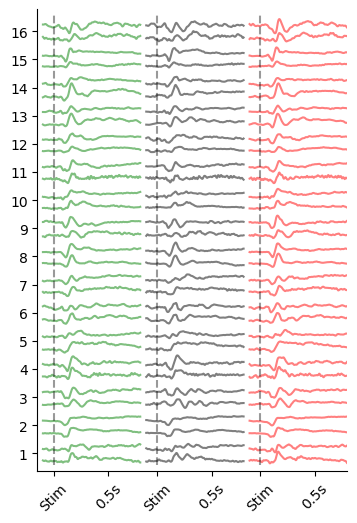

In [13]:
name = 'split' #FT_frob,split

X_train,_ = load_data(data_pool='all',type='mmms',preproc=name)

##################### Figure 1a
plt.figure(figsize=(4,6))

times = torch.load('../data/MEEGtimes.pt')
subdelim = 0.012
modalitydelim = 0.005
x_spacing = 10
t0_idx = 20
ms500_idx = 120

id = [49,98]
# id = [50,20]

for sub in range(16):
    for m,modality in enumerate(X_train):
        # plt.plot(torch.arange(0,180),torch.mean(X_train[modality][sub,:,:180],dim=0)+modalitydelim*m+subdelim*sub,color='green',alpha=0.5)
        # plt.plot(torch.arange(180+x_spacing,370),torch.mean(X_train[modality][sub,:,180:360],dim=0)+modalitydelim*m+subdelim*sub,color='black',alpha=0.5)
        # plt.plot(torch.arange(360+x_spacing*2,560),torch.mean(X_train[modality][sub,:,360:],dim=0)+modalitydelim*m+subdelim*sub,color='red',alpha=0.5)

        plt.plot(torch.arange(0,180),               -X_train[modality][sub,id[m],:180]/12+    modalitydelim*m+subdelim*sub,color='green', alpha=0.5)
        plt.plot(torch.arange(180+x_spacing,370),   -X_train[modality][sub,id[m],180:360]/12+ modalitydelim*m+subdelim*sub,color='black', alpha=0.5)
        plt.plot(torch.arange(360+x_spacing*2,560), -X_train[modality][sub,id[m],360:]/12+    modalitydelim*m+subdelim*sub,color='red',   alpha=0.5)

plt.vlines([t0_idx,180+x_spacing+t0_idx,360+x_spacing*2+t0_idx],ymin=-modalitydelim/2,ymax=subdelim*15+2*modalitydelim,linestyles='dashed',colors='k',alpha=0.4)

plt.ylabel('')
plt.ylim(-modalitydelim,subdelim*15+3*modalitydelim)
plt.xticks([t0_idx,120,180+x_spacing+t0_idx,180+ms500_idx+x_spacing,360+x_spacing*2+t0_idx,360+x_spacing*2+ms500_idx],
           labels=['Stim','0.5s','Stim','0.5s','Stim','0.5s'],rotation=45)
plt.yticks(np.arange(0+modalitydelim/2,16*subdelim,subdelim),labels=np.arange(1,17))
plt.box('off')
# remove spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlim(-10,560)
plt.ylim(16*subdelim,-modalitydelim)
ax.invert_yaxis()
plt.savefig('../figures/Figure1a'+name+'.png',bbox_inches='tight',dpi=300)

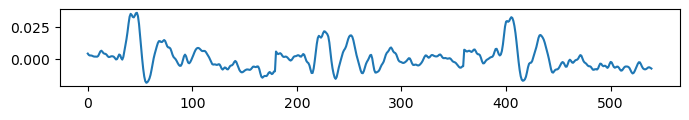

In [12]:
plt.figure(figsize=(8,1))
plt.plot(X_train['MEG'][2,98,:])

In [3]:
from TMMSAA import TMMSAA
from TMMSAA import TMMSAA_trainer
config = load_config()
K=2
modeltype = 'mmms'
times = torch.load('../data/MEEGtimes.pt')
C_idx = torch.tensor(np.tile(times>=0.0,3))
# common initialization
X_train,_ = load_data(data_pool='all',type='group',preproc='split')
print('Calculating group PCA initialization...')
_,_,V_group_pca = torch.pca_lowrank(X_train['all'][...,C_idx],q=K)
init0 = {'Bp':torch.nn.functional.relu(V_group_pca),'Bn':torch.nn.functional.relu(-V_group_pca)}

l1_vals = torch.hstack((torch.tensor(0),torch.logspace(config['lowest_l1_log'],-1,-1-config['lowest_l1_log']+1)))
# lambda1 = 0
lambda2 = 0.1
# loop over group, multimodal, and multimodal+multisubject
X_train,X_test = load_data(data_pool='all',type=modeltype,preproc='split')

for l1,lambda1 in enumerate(l1_vals):
    if l1==0:
        model = TMMSAA.TMMSAA(X=X_train,num_comp=K,model='SPCA',lambda1=lambda1,lambda2=lambda2,init=init0,C_idx=C_idx)
    # model = TMMSAA.TMMSAA(X=X_train,num_comp=K,model='AA',lambda1=lambda1,lambda2=lambda2,init=None,C_idx=C_idx)
    else:
        model = TMMSAA.TMMSAA(X=X_train,num_comp=K,model='SPCA',lambda1=lambda1,lambda2=lambda2,init=init,C_idx=C_idx)

    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    loss,_ = TMMSAA_trainer.Optimizationloop(model=model,optimizer=optimizer,max_iter=config['max_iterations'],tol=config['tolerance'],disable_output=False)
    C,S,Bp,Bn = model.get_model_params()
    # C,S = model.get_model_params()
    init={'Bp':Bp,'Bn':Bn}

Loading data...
Calculating group PCA initialization...
Loading data...
Initializing model: SPCA
Model initialized in 0.3495159149169922 seconds


 16%|█▌        | 7849/50000 [11:41<1:02:48, 11.18it/s]


Tolerance reached at 7850 number of iterations
Initializing model: SPCA
Model initialized in 0.2313985824584961 seconds


  2%|▏         | 1021/50000 [01:42<1:22:10,  9.93it/s]


Tolerance reached at 1022 number of iterations
Initializing model: SPCA
Model initialized in 0.3226156234741211 seconds


  0%|          | 100/50000 [00:08<1:12:13, 11.51it/s]


Tolerance reached at 101 number of iterations
Initializing model: SPCA
Model initialized in 0.32710981369018555 seconds


  0%|          | 105/50000 [00:10<1:19:44, 10.43it/s]


Tolerance reached at 106 number of iterations
Initializing model: SPCA
Model initialized in 0.2976498603820801 seconds


  3%|▎         | 1401/50000 [02:36<1:30:15,  8.97it/s]


Tolerance reached at 1402 number of iterations
Initializing model: SPCA
Model initialized in 0.15960073471069336 seconds


  2%|▏         | 848/50000 [01:13<1:10:43, 11.58it/s]

Tolerance reached at 849 number of iterations


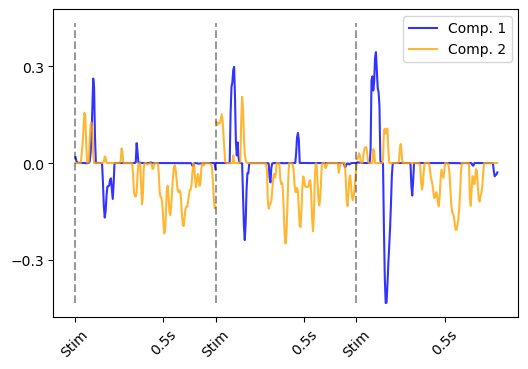

In [27]:
# C matrix
plt.figure(figsize=(6,4));
times = torch.load('../data/MEEGtimes.pt')
times = times[times>=0]
t = np.max(times)
plt.plot(times,C[:len(times),0],color='blue',alpha=0.8);
plt.plot(times,C[:len(times),1],color='orange',alpha=0.8);
plt.plot(times+t,C[len(times):len(times)*2,0],color='blue',alpha=0.8);
plt.plot(times+t,C[len(times):len(times)*2,1],color='orange',alpha=0.8);
plt.plot(times+t*2,C[len(times)*2:,0],color='blue',alpha=0.8);
plt.plot(times+t*2,C[len(times)*2:,1],color='orange',alpha=0.8);
plt.legend(['Comp. 1','Comp. 2']);
plt.vlines([0,t,t*2],ymin=-np.max(np.abs(np.array(C))),ymax=np.max(np.abs(np.array(C))),linestyles='dashed',colors='k',alpha=0.4);
plt.xticks([0,0.5,t,t+0.5,t*2,t*2+0.5],
           labels=['Stim','0.5s','Stim','0.5s','Stim','0.5s'],rotation=45);
plt.yticks([-0.3,0,0.3]);
plt.show();

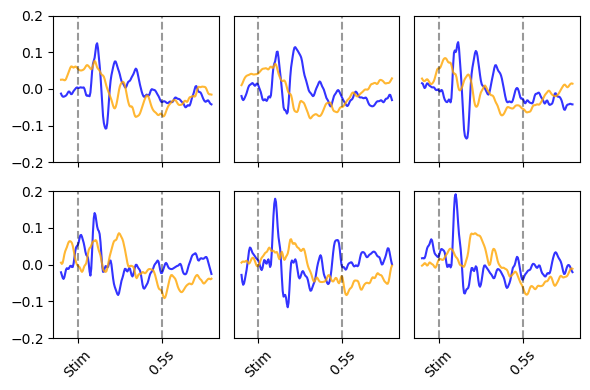

In [28]:
# S matrix
sub = '06'
cols = ['blue','orange']
times = np.array(torch.load('../data/MEEGtimes.pt'))
fig,axs = plt.subplots(2,3,figsize=(6,4))
for m, modality in enumerate(X_train):
    for c in range(3):
        if c==0:
            idx = np.arange(0,180)
        elif c==1:
            idx = np.arange(180,360)
        else:
            idx = np.arange(360,540)
        for k in range(K):
            axs[m,c].plot(times,S[m,int(sub)-1,k,idx],color=cols[k],alpha=0.8)  
        # axs[m,c].set_title(modality)
        axs[m,c].set_ylim(-0.2,0.2)
        axs[m,c].vlines([0,0.5],ymin=-0.2,ymax=0.2,linestyles='dashed',colors='k',alpha=0.4)
        axs[m,c].set_xticks([0,0.5])
        if m==1:
            axs[m,c].set_xticklabels(['Stim','0.5s'],rotation=45)
        else:
            axs[m,c].set_xticklabels([])
        if c==0:
            axs[m,c].set_yticks(np.arange(-0.2,0.21,0.1))
        else:
            axs[m,c].set_yticks([])
# set tight layout
plt.tight_layout()
plt.show()

In [8]:
sub = '06'
# original_data = mne.io.read_raw_fif('/dtu-compute/macaroni/projects/DAA/data/sub-'+sub+'/ses-meg/meg/sub-'+sub+'_ses-meg_task-facerecognition_run-01_meg.fif', preload=False)
# original_info = original_data.info
# evoked = mne.read_evoked_fieldtrip('/dtu-compute/macaroni/projects/DAA/data/processed/sub'+sub+'/timelock_famous_new1.mat',info=original_info,data_name='timelock',comment='None')
# evoked.shift_time(-0.4979, relative=False)
evoked = mne.read_evokeds('../data/JesperProcessed/sub-'+sub+'/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif')[0]
a=evoked.get_channel_types()

Reading /dtu-compute/macaroni/projects/CGD/figures/../data/JesperProcessed/sub-06/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif ...


/tmp/ipykernel_1751896/3120659391.py:6: RuntimeWarning: This filename (/dtu-compute/macaroni/projects/CGD/figures/../data/JesperProcessed/sub-06/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  evoked = mne.read_evokeds('../data/JesperProcessed/sub-'+sub+'/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif')[0]


    Read a total of 1 projection items:
        Average EEG reference (1 x 70) active
    Found the data of interest:
        t =    -100.00 ...     795.00 ms (face/famous)
        0 CTF compensation matrices available
        nave = 148 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correction applied


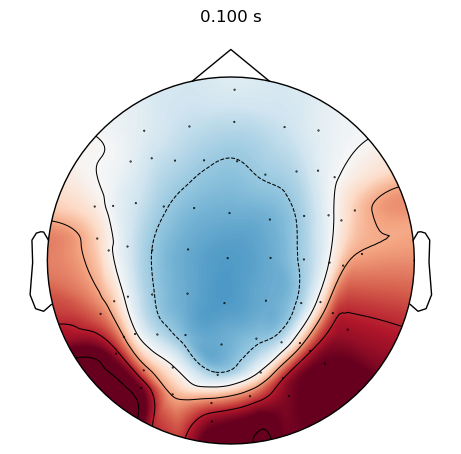

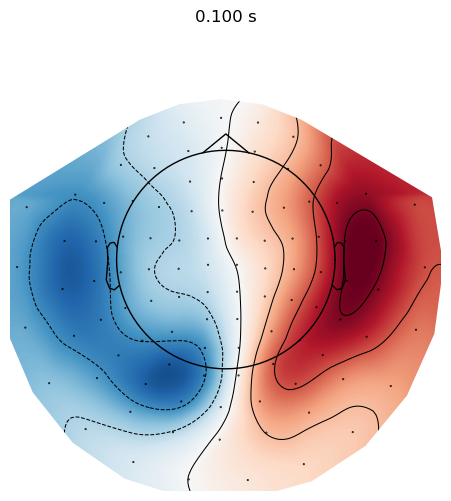

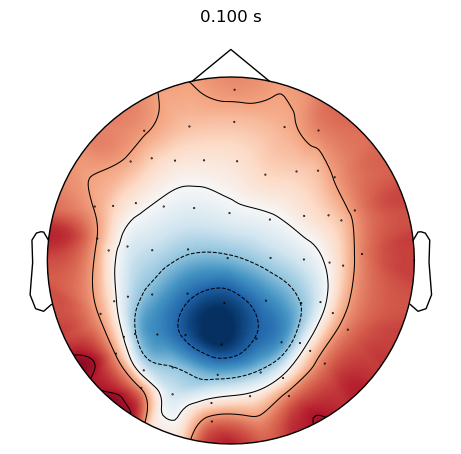

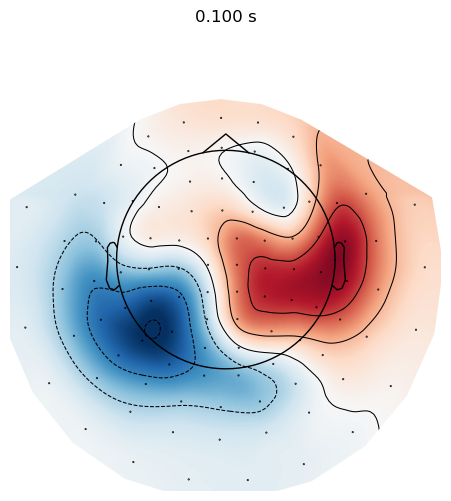

In [11]:
# fig,axs = plt.subplots(2,2,figsize=(12,12))
for k in range(K):
    for m, key in enumerate(X_train):
        XC = np.array(X_train[key][int(sub)-1,:,C_idx]@C[:,k])
        if key=='EEG':
            ch_type = 'eeg'
            evoked.data[np.where(np.array(a)==ch_type)] = np.tile(XC,(180,1)).T
        elif key=='MEG':
            ch_type = 'mag'
            evoked.data[np.where(np.array(a)==ch_type)] = np.tile(XC,(180,1)).T
        
        evoked.plot_topomap(times=[0.1],ch_type=ch_type,show_names=False,colorbar=False,size=3,res=128,extrapolate='auto',sphere=(0.0, 0.0, 0.0, 0.09));

Reading /dtu-compute/macaroni/projects/CGD/figures/../data/JesperProcessed/sub-06/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif ...


/tmp/ipykernel_3014665/2001434213.py:1: RuntimeWarning: This filename (/dtu-compute/macaroni/projects/CGD/figures/../data/JesperProcessed/sub-06/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  evoked = mne.read_evokeds('../data/JesperProcessed/sub-'+sub+'/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif')[0]


    Read a total of 1 projection items:
        Average EEG reference (1 x 70) active
    Found the data of interest:
        t =    -100.00 ...     795.00 ms (face/famous)
        0 CTF compensation matrices available
        nave = 148 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correction applied


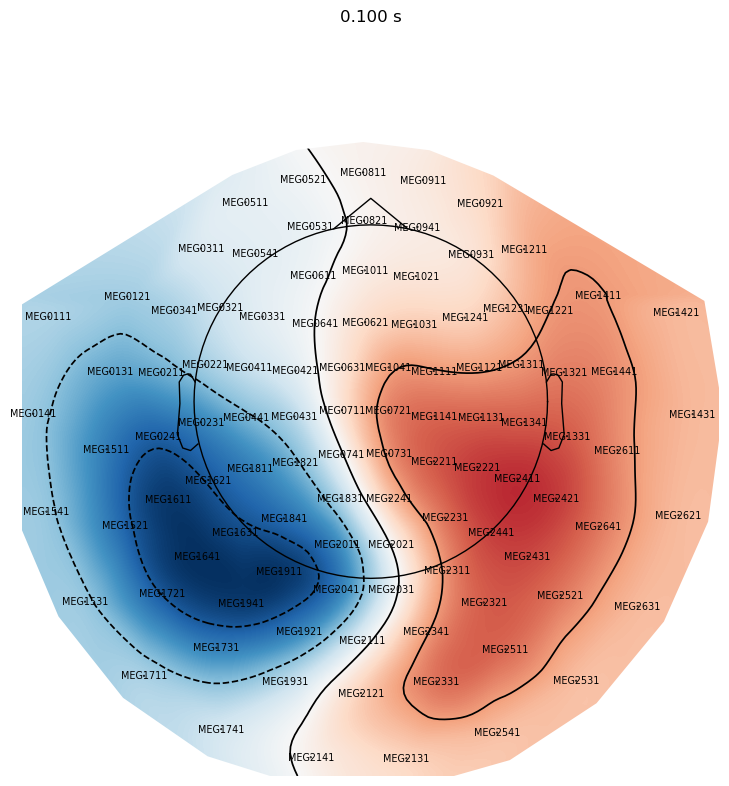

In [7]:
evoked = mne.read_evokeds('../data/JesperProcessed/sub-'+sub+'/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif')[0]
evoked.plot_topomap(times=[0.1],ch_type='mag',show_names=True,colorbar=False,size=5,res=128,extrapolate='auto',sphere=(0.0, 0.0, 0.0, 0.09));

Reading /dtu-compute/macaroni/projects/CGD/figures/../data/JesperProcessed/sub-06/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif ...


/tmp/ipykernel_3014665/861510189.py:1: RuntimeWarning: This filename (/dtu-compute/macaroni/projects/CGD/figures/../data/JesperProcessed/sub-06/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  evoked = mne.read_evokeds('../data/JesperProcessed/sub-'+sub+'/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif')[0]


    Read a total of 1 projection items:
        Average EEG reference (1 x 70) active
    Found the data of interest:
        t =    -100.00 ...     795.00 ms (face/famous)
        0 CTF compensation matrices available
        nave = 148 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correction applied


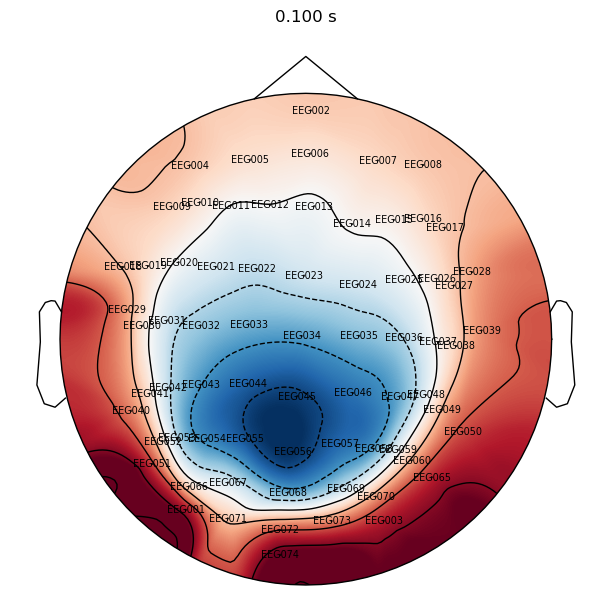

In [8]:
evoked = mne.read_evokeds('../data/JesperProcessed/sub-'+sub+'/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif')[0]
evoked.plot_topomap(times=[0.1],ch_type='eeg',show_names=True,colorbar=False,size=4,res=128,extrapolate='auto',sphere=(0.0, 0.0, 0.0, 0.09));

Reading /dtu-compute/macaroni/projects/CGD/figures/../data/JesperProcessed/sub-06/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif ...


/tmp/ipykernel_3014665/3883494568.py:1: RuntimeWarning: This filename (/dtu-compute/macaroni/projects/CGD/figures/../data/JesperProcessed/sub-06/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  evoked = mne.read_evokeds('../data/JesperProcessed/sub-'+sub+'/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif')[0]


    Read a total of 1 projection items:
        Average EEG reference (1 x 70) active
    Found the data of interest:
        t =    -100.00 ...     795.00 ms (face/famous)
        0 CTF compensation matrices available
        nave = 148 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correction applied


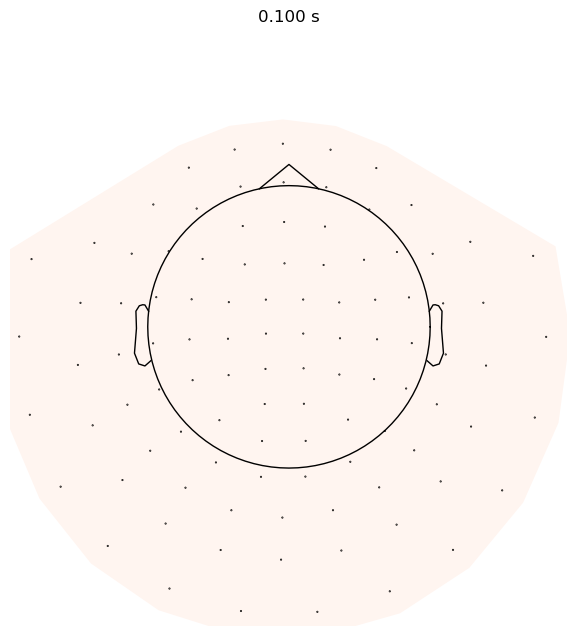

In [13]:
evoked = mne.read_evokeds('../data/JesperProcessed/sub-'+sub+'/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif')[0]
evoked.data = np.zeros((376,180))
evoked.plot_topomap(times=[0.1],ch_type='mag',show_names=False,colorbar=False,size=4,res=128,extrapolate='auto',sphere=(0.0, 0.0, 0.0, 0.09));

Reading /dtu-compute/macaroni/projects/CGD/figures/../data/JesperProcessed/sub-06/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif ...


/tmp/ipykernel_3014665/1609924756.py:1: RuntimeWarning: This filename (/dtu-compute/macaroni/projects/CGD/figures/../data/JesperProcessed/sub-06/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  evoked = mne.read_evokeds('../data/JesperProcessed/sub-'+sub+'/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif')[0]


    Read a total of 1 projection items:
        Average EEG reference (1 x 70) active
    Found the data of interest:
        t =    -100.00 ...     795.00 ms (face/famous)
        0 CTF compensation matrices available
        nave = 148 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correction applied


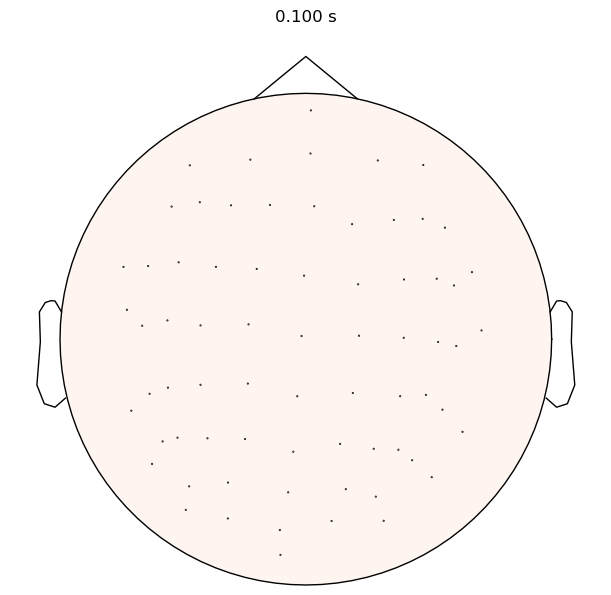

In [12]:
evoked = mne.read_evokeds('../data/JesperProcessed/sub-'+sub+'/ses-meg/stage-preprocess/task-facerecognition_proc-p_cond-famous_split-0_evo.fif')[0]
evoked.data = np.zeros((376,180))
evoked.plot_topomap(times=[0.1],ch_type='eeg',show_names=False,colorbar=False,size=4,res=128,extrapolate='auto',sphere=(0.0, 0.0, 0.0, 0.09));